## Linear Regression 

### Stochastic Gradient Descent Linear Regression & OLS Polynomial Regression

***Author: Rabindra Nepal***

*Email: rnepal2@unl.edu*

*Format prepared by M.R. Hasan*


There are four parts in this notebook:
- Perform Linear Regression using sklearn's SGDRegressor
- Perform Polynomial Regression using sklearn's OLS method
- Plot degree vs. error to choose optimal degree for a fixed set datasize
- Plot learning curves to investigate how the size of training data influeces the model performance for various polynomial models

We will use the **Red wine** quality dataset from the following link.

### Dataset

Source: https://archive.ics.uci.edu/ml/datasets/wine+quality

The dataset is related to the **Red** variants of the Portuguese "Vinho Verde" wine. It provides the physicochemical (inputs) and sensory (the output) variables are available.

The dataset consists of characteristics of white wine (e.g., alcohol content, density, amount of citric acid, pH, etc) with target variable "quality" representing rating of wine.


Given the characteristics of a new, unlabeled wine, the regression task is to predict its "quality".

Input variables (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data): 
- quality 


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
#import searborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Load Data

First load the data and explore the feature names, target names, etc.

In [2]:
# Load data
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Exploratory Data Analysis

Perform EDA and determine the following:
- Are the input variables collinear?
- Do you need to drop any input variable column? 

Drop the redundant columns if need be. However, if dropping a column doesn't achieve the best accuracy, then don't drop it.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


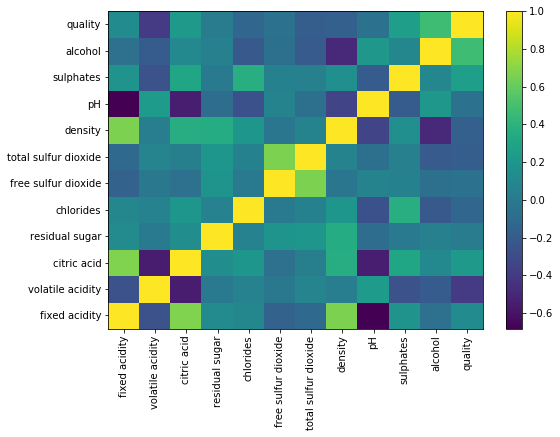

In [4]:
# Understanding the data correlation with following heatmap

fig, ax = plt.subplots();
fig.subplots_adjust(bottom=0.25,left=0.25)

heatmap = ax.pcolormesh(df.corr())
plt.colorbar(heatmap)

# ticks in the middle
ax.set_xticks(np.arange(df.corr().shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(df.corr().shape[0]) + 0.5, minor=False)

# ticks labels
headers = df.columns.values # ticks
ax.set_xticklabels(headers, rotation=90)
ax.set_yticklabels(headers);

# fig size
fig.set_size_inches(w=10,h=7);

In [5]:
# correlation of the features with target feature: quality
df.corr()['quality'].abs().sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

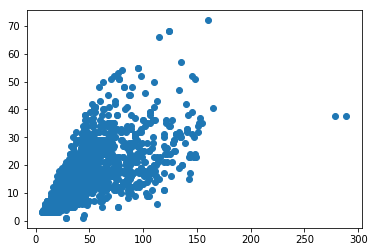

In [6]:
plt.scatter(df['total sulfur dioxide'], df['free sulfur dioxide']);

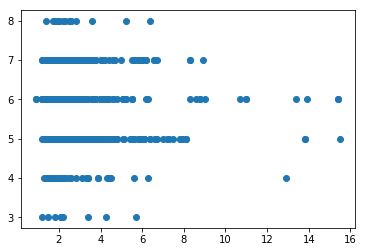

In [7]:
plt.scatter(df['residual sugar'], df['quality']);

Based on various experimentations and features analysis: we drop only a single feature "free sulfur dioxide" and work with rest of the features ahead. Dropping any of these features does't significantly increase or decrease (upto few) the performance of the mode. Looking into the heatmap above showing the correlation of each features with the quality/target variable and their inter-correlation, I am dropping "free sulfur dioxide" and will be keeping rest of the features in the rest of the discussion.

In [8]:
X = df.drop(columns=['free sulfur dioxide'], inplace=False)

In [9]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Creating a Separate Feature Set (Data Matrix X) and Target (1D Vector y)

Let us create a data matrix (X) that contains all features and a 1D target vector (y) containing the target.

In [10]:
y = df['quality']  # target 
X = X.drop(columns=['quality'], inplace=False)  # feature df

In [11]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,34.0,0.9978,3.51,0.56,9.4


### Features scaling

We should ensure that all features have a similar scale. Otherwise optimization algorithms (e.g., Gradient Descent based algorithms) will take much longer time to converge.

Also, regularization techniques are sensitive to the scale of data. Thus, we must scale the features before applying regularization.

In [12]:
# scaling the features
scale = StandardScaler().fit(X)
X = scale.transform(X)

### Create Train and Test Dataset


In [13]:
# creating training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Implementation of Sklearn's Stochastic Gradient Descent (SGD)


Performing linear regression by using sklearn's SGDRegressor - will use **regularized** SGDRegressor.

First, we will select the best model via hyperparameter tuning using sklearn's GridSearchCV.

Find the best combination of the following hyperparameters. 

- alpha
- learning_rate ("constant", "optimal")
- eta0
- l1_ratio
- max_iter
- eta0


For regression, you may use "neg_mean_squared_error" or "explained_variance" scoring function. 

### Hyperparameter Tuning for SGD Regressor

We can use following hyper-parameters. Below this tuning might take some time.
- alpha: 0.1, 0.01, 0.001
- learning_rate: "constant", "optimal"
- l1_ratio': from 0 to 1
- max_iter': try larger iterations from 10000
- eta0: 0.01, 0.001

#### Report the best score (negative mean squared error) & optimal hyperparameter values.

In [14]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [15]:
#param_grid={'alpha': [0.1, 0.01, 0.001], learning_rate:['constant', 'optimal'], 'l1_ratio': [0, 1], 'max_iter'}

sgd = SGDRegressor(max_iter=1000, eta0=0.001, learning_rate='optimal', penalty="elasticnet", l1_ratio=0.9, alpha=0.001)

sgd.fit(X_train, y_train)

# The intercept
print("Intercept: \n", sgd.intercept_)
# The coefficients
print("Coefficients: \n", sgd.coef_)
# The number of iterations
print("Number of Iterations: \n", sgd.n_iter_)

print('----------Model Evaluation----------')
# Make prediction 
y_train_predicted_sgd = sgd.predict(X_train)
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_predicted_sgd))

# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % 
      r2_score(y_train, y_train_predicted_sgd))

Intercept: 
 [5.63285438]
Coefficients: 
 [ 0.04958187 -0.186935   -0.02955716  0.02365603 -0.08083137 -0.07813883
 -0.02159843 -0.0538011   0.14033118  0.3041738 ]
Number of Iterations: 
 1000
----------Model Evaluation----------
Mean squared error: 0.43
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.34


In [16]:
result=pd.DataFrame({'y_true': y_train, 'y_pred': y_train_predicted_sgd})
result.sample(5)

,y_true,y_pred
40,5,5.800468
1292,6,6.322049
651,5,5.171990
532,5,5.787066
869,6,5.641552


In [17]:
# param_grid = {'alpha': [0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.95, 0.90], 'max_iter':[1000, 10000],'eta0': [0.01, 0.001]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=10)
# sgd_cv.fit(X_train, y_train)

# print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

### Select The Best Model for the SGD Regressor

Using the optimal hyperparameter values, we create the best model.
Then, will fit the model.


and will calculate evaluation metrics.

In [18]:
# SGD Regression using the best model
# Create SGDRegressor model with best model parameters obained above

sgd = SGDRegressor(max_iter=10000, learning_rate="constant", eta0=0.001, penalty="elasticnet", l1_ratio=1.0, alpha=0.001)

# Train the model
sgd.fit(X_train, y_train)

# The intercept
print("Intercept: \n", sgd.intercept_)

# The coefficients
print("Coefficients: \n", sgd.coef_)

# The number of iterations
print("Number of Iterations: \n", sgd.n_iter_)

print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction on the training data
y_train_predicted_sgd = sgd.predict(X_train)

print("Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))

# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % 
      r2_score(y_train, y_train_predicted_sgd))

Intercept: 
 [5.62161346]
Coefficients: 
 [ 0.04708321 -0.18777258 -0.02932414  0.01947739 -0.07099637 -0.07586892
 -0.01989014 -0.05704622  0.14822462  0.2952298 ]
Number of Iterations: 
 10000

----------------------------- Model Evaluation -----------------------------
Mean squared error: 0.43
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.34


### Evaluate Model Performance Using Test Data

In [19]:
# Make prediction using the test data

y_test_predicted = sgd.predict(X_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))

# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % 
      r2_score(y_test, y_test_predicted))

Mean squared error: 0.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.41


### <font color=blue>Polynomial Regression Using the OLS Method</font>



### Choose the Optimal Degree (Model Complexity) of the Polynomial Regression

Vary the degree of the polynomial (degree 1, 2 & 3) and train the sklearn's Linear Regression model (OLS) using the training data. Then, compute the mean squared error (mse) for the test data using the models with varying degree.

Finally, plot the **root mean square error (rmse)** values against the varying degree. From this plot find the optimal degree (that gives the smallest rmse).


### Model's Complexity: Overfitting or Underfitting
If a model performs well on the training data but generalizes poorly (on the validation data) according to the cross-validation metrics, then the model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

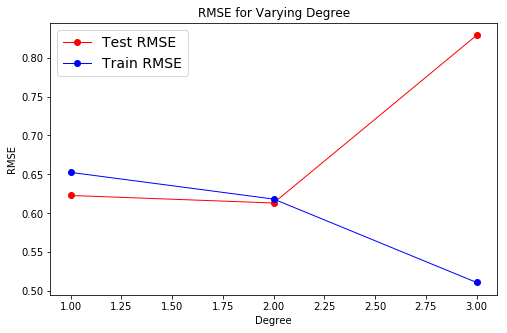

In [20]:
# RMSE vs. Degree Curve

degrees = [1,2,3]
mse_train, mse_test = [], []
for degree in degrees:

    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
    model.fit(X_train, y_train)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    # mse calculation
    mse_train.append(mean_squared_error(y_train, y_train_predicted))
    mse_test.append(mean_squared_error(y_test, y_test_predicted))
   
plt.figure(figsize=(8, 5))   
plt.plot(degrees, np.sqrt(mse_test), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(degrees, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

### Determine Model Complexity using Learning Curve

Determine  polynomial regression model's complexity (whether it's overfitting or underfitting) by creating learning curves by varying the degree of polynomial. 

By plotting the learning curves.

We will generate two set of learning curves.
- Linear Model
- 4th Degree Polynomial Model

Our goal is to investigate whether the two models are overfitting or underfitting. 

### Learning Curve: Linear Model

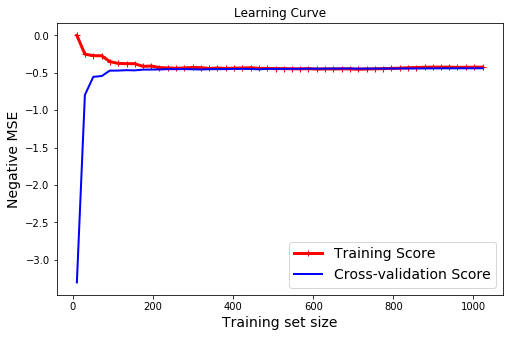

In [21]:
# Learning Curve: Linear Model

# Create CV training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)
                                                
                                                                                                                                                                                                                 
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve")
plt.show()


### Observation: Linear Model Learning Curve

#### Conclusion: 
From the learning curve above, it seems that the model is underfitting the data i.e. the model may be too simple to fit with the data to give accurate predictions. 

#### Justification:
While training the model is fitting perfectly when there is small number of training samples at the beginning. But it quickly loses track of the data and the mean square error becomes large once we start introducing more training data to the model leading to a plateau where the model becomes independent of any further training data. Whereas, the cross validation starts with a big error at the beginning as the simple trained model only performs well during the training but doesn't predict correctly with validation data. Once the model is trained with the sufficient data, the validation error also increases and reach almost the trainig performance. 

But the performance of the model is not good on both the training and validation even after sufficient training - which is the typical problem of underfitting - i.e. the original model itself is too simple to grasp the complex correct prediction model hidden in the features dataset. 

### Learning Curve: Polynomial Model (4th degree)

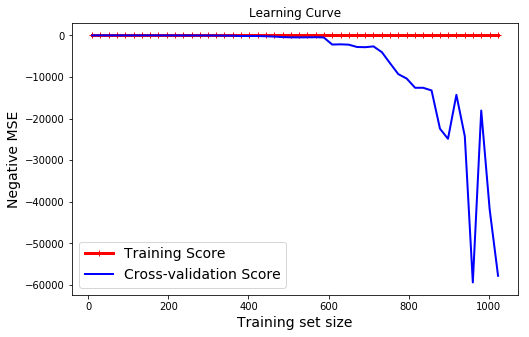

In [22]:
# Learning Curve: Polynomial (4th Degree) Model
# polynomial degree
degree = 4


# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
polyFeatures = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
X_train_poly = polyFeatures.fit_transform(X_train)


# scaling features
scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)


train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# plotting
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve")
plt.show()

### Observation: Polynomial Model (4th degree) Learning Curve

##### Conclusion:
The 4th order polynomial model has significantly increased the performance of the model - but variance is also increased. All in all, it is about **bias-variance trade-off** and we can regularize to select the optimal model.



##### Justification:
As seen in plots above, the increase in the polynomial order of the model from 1 to 4 has significantly increased on the performance of the model with much smaller mse. But the variance has been significantly increased at the same time which is leading to such a steep change in mse in validation scores shown above. Accordingly, there has not been increase in the overall performace of the model as seen in the calculation below. 

#### Let's exlore more...

In [23]:
model = ElasticNet(alpha=0.001, l1_ratio=0.25, max_iter=1000000, tol=0.00001, random_state=10)
model.fit(X_train_poly_standardized, y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000000, normalize=False, positive=False, precompute=False,
      random_state=10, selection='cyclic', tol=1e-05, warm_start=False)

In [24]:
y_train_pred = model.predict(X_train_poly_standardized)

In [25]:
print('mse: ', mean_squared_error(y_train, y_train_pred))
print('r2_score: ', r2_score(y_train, y_train_pred))

mse:  0.17370377301828266
r2_score:  0.733006829347174


In [26]:
# prediction on test data

In [27]:
polyFeatures = PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)
X_test_poly = polyFeatures.fit_transform(X_test)

scaler = StandardScaler().fit(X_test_poly)
X_test_poly_std = scaler.transform(X_test_poly)

# prediction
y_test_pred = model.predict(X_test_poly_std)

In [28]:
print('mse: ', mean_squared_error(y_test, y_test_pred))
print('r2_score: ', r2_score(y_test, y_test_pred))

mse:  1.479493478361865
r2_score:  -1.2639329963725543


Oh! a classic overfitting! Regularization seems critical.

***Done!***